# Introduction to Bandit Problems

## CSCI E-82A
## Stephen Elston

Interest in **bandit problems** has a long history, starting in the 1940s. Bandit problems seem simple, but actually can be complex and hard to understand. There are a great number of bandit algorithms. In this lesson we will only look at the simplest case of an **exploring bandit algorithm**.   

Bandit algorithms are surprisingly useful in practice. For example, in the past 10 years a number of researchers have incorporated variations on bandit algorithms into recommender systems. Bandit algorithms are used along with or as an alternative to matrix factorization methods. See for example the paper by [Louedec, et. al.](https://www.aaai.org/ocs/index.php/FLAIRS/FLAIRS15/paper/view/10385/10364).

**Suggested reading:** An overview of several interesting and useful variations on bandit algorithms can be found in Chapter 2 of Sutton and Barto, second edition.  

## What are Bandits?

The name *Bandit* comes from the common name used for gambling slot machines. An example of a **one-armed** bandit in a casino is shown below.

<img src="img/OneArmedBandit.JPG" alt="Drawing" style="width:300px; height:300px"/>
<center> **A Physical One Armed Bandit** </center>  

 A player places a bet (inserts a token) into the bandit, and then pulls the lever. The player then receives a **reward**. The reward may be negative, the player has lost the amount bet. With some non-zero probability, a *lucky* player receives a positive reward and is considered to have won the game. It should come as no surprise that casinos set the probability of payout in a way that ensure **the house always wins** with high probability. 
 
 This idea can be extended to a conceptual **multi-armed** bandit. The multi-armed bandit works in much the same way as the one armed bandit. The agent tries to optimize the reward by **learning** a **policy** of which lever is most likely to pay out. The cartoon below illustrates this idea.  

<img src="img/multiarmedbandit.JPG" alt="Drawing" style="width:300px; height:200px"/>
<center> **A Conceptual Muti-Armed Bandit and an Agent Learning Optimal Policy**    
Attribution: Microsoft Research</center>  

The bandit problem is a simple version of a **reinforcement learning** problem:
- The agent must learn the behavior of the environment by trial and error. The bandit is therefore model free. 
- The agent can take actions (pull a lever) in the environment. 
- The agent receives rewards (positive or negative) from the environment. 

## Multi-Armed Bandit Model

For this lesson we will use a simple bandit model. The agent received a positive reward of 1 with probability $p_k$ when pulling the kth lever. Otherwise the agent receives a reward of 0. We model this behavior as a series of **Bernoulli trials**. Bernoulli distributions model the outcomes of trials or experiments with binary outcomes. For example, pulling a lever two possible end states, $\{ win:1,\ loose:0 \}$. 

For an event with a binary outcome, ${0,1}$ with probability $p$ of state 1, we can write the probability mass function for the Bernoulli distribution as:

$$
P(x\ |\ p) = \bigg\{ 
\begin{matrix}
p\ if\ x = 1\\
(1 - p)\ if\ x = 0
\end{matrix}\\
or\\
P(x\ |\ p) = p^x(1 - p)^{(1-x)}\ x \in {0, 1}
$$

The agent uses a **policy**, $\pi$, to determine which action to take. The expected **action value** given the action, $a$, by the policy is:   

$$q_{\pi}(a) = \mathbb{E}_{\pi} [R_{t}\ |\ A_t = a] $$

Our goal is to find an **optimal policy** which maximizes the expected action value. We say that the optimal policy, $q_*(a)$, gives the highest expected value for the action $a$:

$$q_{\pi^*}(a) = \mathbb{E}_{\pi^*} [R_{t}\ |\ A_t = a] $$

An optimal policy has an expected action value greater than or equal to all possible policies:

$$q_{\pi^*}(a) \ge q_{\pi}(a)\ \forall\ \pi$$ 

The optimal policy can then be written:   

$$q_{\pi^*}(a) = \mathbb{E}_{\pi^*} [R_{t}\ |\ A_t = a] = \underset{a^*}{max}\ \mathbb{E}[R_{t}\ |\ A_t = a^*]$$

The bandit model is stateless. Thus, there is no state required for the representation.

For our multi-armed bandit, $p_k$ can be different for each lever. The agent must therefore try to find the optimal policy of which lever(s) to pull to maximize reward. There are two approaches an agent can take:  
1. Pull each lever a few times and then estimate $p_k$ for each lever. The agent then adopts the policy of pulling the best lever(s) exclusively. We say that this algorithm **exploits** the best known policy. The problem is, that $p_k$ is only an estimate and there is a significant chance that the best levers are not selected from a finite number of pulls.   
2. Alternatively, the agent can use an **exploring algorithm**. The exploring algorithm does the following:
  -  With some small probability, $\epsilon$, the agent takes an **exploring action** by pulling a lever at random. The estimate of $p_k$ for the lever pulled is then updated. It is possible a better policy might be discovered during this exploring step. 
  - With probability $1 - \epsilon$ the agent exploits the best known policy. 
  
The second algorithm is known as an **$\epsilon$-greedy** method. This algorithm exhibits a key trade-off in reinforcement learning, between exploration to improve policy and exploitation of the best known policy.

## Bandit Agent Model

The relationship between the **bandit agent** and the **environment** is illustrated in the figure below. 

<img src="img/BanditAgent.JPG" alt="Drawing" style="width:400px; height:300px"/>
<center> **Bandit Agent and Environment Model**</center>  

The bandit agent is **model free**, which means that, initially it has no information on the response of the environment to the agent's actions. The agent gains information on the the environment by receiving **rewards** or utility information from the environment in response to **actions** the agent initiates in the environment. The environment informs the agent of the reward based on the agent's action, but without revealing the environment's underlying operation.   

The bandit model is suitable for a **stateless** environment. Here the agent can pull any lever of the multi-armed bandit at any time. The environment (multi-armed bandit) has no state, and the expected reward for pulling a particular lever remains the same regardless of the sequence of events. 

The diagram above illustrates the key functions of the agent:
- **Representation:** The representation in this case is simple. The agent maintains an estimate of the probability of success for each lever tried. In this particular example, we allow the agent to know the number of possible levers as part of its representation.  
- **Learning:** The agent learns the probability of success based using the results of pulling levers. 
- **Inference:** The agent makes an **inference** to determine which lever to pull using the estimated probabilities of success in the representation. For **greedy** algorithms, the agent choses to pull the lever with the highest estimated probability of success. For $\epsilon$-greedy algorithms, the agent's inference is to pull a random lever with probability $\epsilon$ or choose the greedy action with probability $1-\epsilon$. 

## A Computational Example

Let's try an example of a 10-armed bandit problem. The components we need for this example are:
- **Environment simulator:** The arguments to this function are the actions the agent requests. In this case, the lever to pull and the number of pulls. 
- **Exploitation or greedy algorithm:** This algorithm **exploits** the current representation by continually pulling the lever with the highest estimated probability of success. The function makes multiple calls to the environment simulator and receives the rewards from pulling the best known lever.  
- **Exploratory algorithm**. This algorithm uses the environment simulator to either exploit the lever with the best chance of success with with probability $1-\epsilon$ or pulls a random lever with probability $\epsilon$. The algorithm uses the reward received from the environment simulator to update its estimate of the lever with the highest probability of success. 

The code in the cell below imports the packages you will need. Execute this code.

In [70]:
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Environment simulation

The bandit agent is **model free** and therefore has no knowledge of the environment. The agent causes actions in the environment (pulls a lever) and receives rewards from the environment.     

The code in the cell below defines an environment simulator function. The agent calls the simulator with the index of the lever to pull and the number of pulls. The simulator returns the success or failure from the pull. The probabilities for each lever simulated are defined in a list. 

Execute this code to test the simulator. 

In [71]:
n_levers = 10
def simulate_pulls(lever, pulls = 1, probabilities = [0.24, 0.28, 0.32, 0.36, 0.40, 0.44, 0.48, 0.52, 0.56, 0.60]):
    '''Function to simulate the environement given the
    index of the lever to pull and the number of pulls'''
    ## return the Binomially distributed result
    return list(nr.binomial(n=1, p = probabilities[lever], size = pulls))

[simulate_pulls(i, pulls = 10) for i in range(10)]

[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 1, 0, 1, 1],
 [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
 [0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 1, 0, 1],
 [1, 1, 1, 1, 1, 1, 0, 1, 0, 1]]

As one should expect, the outcomes of each set of pulls are quite different. 

As a next step, let's examine the distribution of the $p_k$ values for a number of pulls on each lever. The function in the cell below calls the environment simulator a number of times for each of the levels. Execute the code to create a data frame of the realizations and examine the head. 

In [72]:
def compute_p(n_samples, n_pulls_sample, n_levers = n_levers):
    '''Estimates the binomial probability, p, all 10 
    bandit levers for n_samples with n_pulls_sample 
    samples in each set of pulls'''
    samples = [simulate_pulls(i, pulls = n_pulls_sample) for i in range(n_levers)]
    p = np.mean(samples, axis = 1)
    for _ in range(n_samples - 1):
        samples = [simulate_pulls(i, pulls = n_pulls_sample) for i in range(n_levers)]
        p = np.concatenate((p, np.mean(samples, axis = 1))) #, axis = 1)
    return pd.DataFrame(p.reshape(n_samples, n_levers))
    
nr.seed(445)
estimates = compute_p(100, 100)    
estimates.head()

,0,1,2,3,4,5,6,7,8,9
0,0.27,0.23,0.38,0.32,0.44,0.42,0.36,0.49,0.55,0.68
1,0.24,0.28,0.37,0.38,0.49,0.50,0.45,0.52,0.55,0.61
2,0.24,0.25,0.30,0.35,0.50,0.40,0.42,0.50,0.62,0.56
3,0.26,0.30,0.35,0.42,0.40,0.38,0.53,0.58,0.57,0.64
4,0.24,0.30,0.30,0.34,0.36,0.38,0.43,0.50,0.60,0.54


Examine the head of this table, noticing that the values of $p_k$, for each lever, are quite different from experiment to experiment. To get a feel for this variability, execute the code in the cell below to display violin plots of the distribution of $p_k$ for each lever.

C:\Users\StevePC2\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


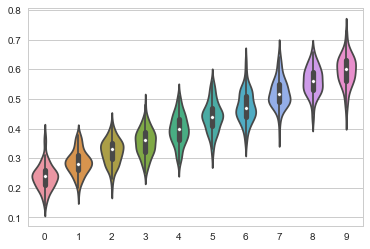

In [73]:
sns.set(style="whitegrid")
sns.violinplot(data = estimates)

From this chart you can see the considerable variation in the estimated values of $p_k$. Still average the vales of pulling each of the levers is considerably different. 

### Exploitation Algorithm

As a next step, let's try a simple exploitation algorithm. In the cell below, a function to find a policy is defined. The values of $p_k$ are estimated based on 5 pulls of each lever. Policy is determined by choosing the lever with the maximum $p_k$. **Ties are broken** by arbitrarily selecting the first lever in a list of possibilities. 

In [74]:
def find_max_lever(n_pulls, n_levers = n_levers):
    vals = [simulate_pulls(i, pulls = n_pulls) for i in range(n_levers)]
    p = np.mean(vals, axis = 0)
    max_p = np.max(p)
    return np.where(p == max_p)[0][0]

nr.seed(6445)
max_bandit = find_max_lever(n_pulls = 5)
max_bandit

4

We have found the **optimal policy** based on the limited sample. The code in the cell below defines a function which simulates 1,000 pulls of the lever determined to be optimal. The average accumulated reward for each time step is computed by dividing the cumulative sum of rewards by the number of time steps. 

In [75]:
def exploit(n_samps, max_bandit):
    ## Find the reward for each of the pulls
    samples = [simulate_pulls(max_bandit) for _ in range(n_samps)]
    ## Find the cumulative reward and then normalize by the number of pulls
    samples = np.cumsum(samples)
    proportion = [s/float(i+1) for i,s in enumerate(samples)]
    return proportion

prob_success = exploit(10000, max_bandit)

Execute the code in the cell below to plot the average reward accumulated at each time step.  

Text(0, 0.5, 'Aerage reward')

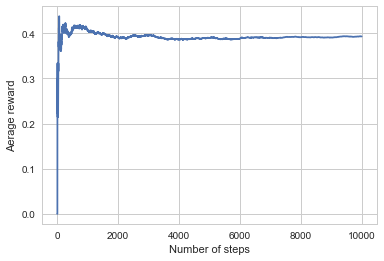

In [76]:
plt.plot(prob_success)
plt.xlabel('Number of steps')
plt.ylabel('Aerage reward')

As you might expect, the average reward for this exploiting approach converges to the value of $p_k$ for the lever chosen for the policy. This result highlights an important property of greedy algorithms. They have no way to improve. 

## Exploring Algorithm

The function defined in the cell below implements a simple exploring algorithm. Policy is improve as the algorithm proceeds through the time steps. The algorithm works as follows:    
1. The algorithm loops over a number of **episodes**. The mean of the accumulated rewards is computed over the results of each episode. 
2. Within each episode an initial random policy is selected.
3. An inner loop iterates over the number of time steps of samples in each episode
4. With probability $\epsilon$ a random exploration step is taken. If the policy can be improved the new policy is adopted. 
5. The average accumulated rewards are computed. To limit memory use, the following commonly used update  expression is applied:   
$$NewEstimate \leftarrow OldEstimate + StepSize * \big[Target - OldEstimate \big]\\
where\ the\ error\ term\ is\\
\big[Target - OldEstimate \big]$$

Specific details of this code can be learned by reading the comments. 

Execute the code for 100 episodes of 10,000 samples using $\epsilon = 0.01$. The execution may take some time 

In [86]:
def explore(epsilon): return nr.uniform() < epsilon

def update_prob_count(current_prob_count, bandit, sample):
    '''Function does the bookkeeping of the probability 
    of success for each of the levers'''
    current_prob_count[bandit,0] = (current_prob_count[bandit,1] * current_prob_count[bandit,0] + sample)/(current_prob_count[bandit,1] + 1)
    current_prob_count[bandit,1] = current_prob_count[bandit,1] + 1
    return current_prob_count
    

def exploit_explore(n_samps, epsilon, n_levers = n_levers):
    '''Function to execute a the samples for an episodes'''
    samples = []
    ## Choose a random lever to start the episode
    max_bandit = nr.choice(range(n_levers))
    ## Initialize an array to do the bookkeeping to determine the best bandit
    current_prob_count = np.zeros((n_levers,2))
    for _ in range(n_samps):
        if explore(epsilon): 
            ## Exploring, so choose a random lever to pull
            new_bandit= nr.choice(range(n_levers))
            ## Pull the lever and update the stats.
            samples.append(simulate_pulls(new_bandit))
            current_prob_count = update_prob_count(current_prob_count, new_bandit, samples[-1])
            ## Find the bandit with the largest probability of success
            max_bandit = np.argmax(current_prob_count[:,0])
        else: ## Or, exploit 
            ## Pull the lever and update the stats.
            samples.append(simulate_pulls(max_bandit))
            current_prob_count = update_prob_count(current_prob_count, max_bandit, samples[-1])
    return(np.array(samples).flatten())    

def e_greedy(n_samps, episodes, epsilon):
    results = np.zeros((episodes,n_samps))
    for i in range(episodes): ## Iterate over the episodes
        results[i,:] = exploit_explore(n_samps, epsilon)
    ## Return the average return for at each time step    
    return [s/(x + 1) for s,x in zip(np.cumsum(np.mean(results, axis = 0)), range(n_samps))]    

nr.seed(33355)
prob_success = e_greedy(10000, 100, 0.01)

Execute the code in the cell below to display a plot of the average reward by time step. 

Text(0, 0.5, 'Aerage reward')

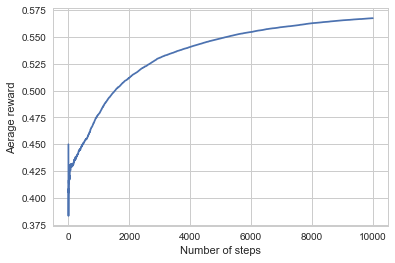

In [87]:
plt.plot(prob_success)
plt.xlabel('Number of steps')
plt.ylabel('Aerage reward')

The average reward slowly converges to the value of $p_k$ for the best lever. The policy is clearly being improved. 

Next, let's try another value of the exploitation-exploration trade-off parameter, $\epsilon = 0.2$. In this case, every fifth step will be exploratory, whereas for the first example every 100th step was exploratory. The question is, how does this change performance of the algorithm?

Text(0, 0.5, 'Aerage reward')

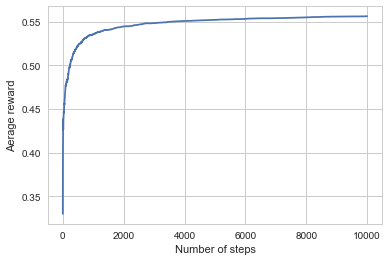

In [88]:
nr.seed(7879)
prob_success = e_greedy(10000, 100, 0.2)

plt.plot(prob_success)
plt.xlabel('Number of steps')
plt.ylabel('Aerage reward')                        

With  $\epsilon = 0.2$ convergence is much faster. However, on average one out of five steps requires the extra work of exploration. In this case, the trade-off seems well worth it, since convergence appears to occur in about half as many time steps. 

Finally, it is worth checking how this algorithm behaves with  $\epsilon = 0.0$, the pure exploitation case. 

Text(0, 0.5, 'Aerage reward')

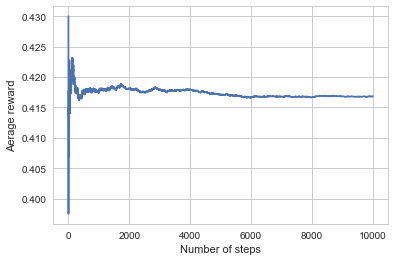

In [89]:
nr.seed(7880)
prob_success = e_greedy(10000, 100, 0.0)

plt.plot(prob_success)
plt.xlabel('Number of steps')
plt.ylabel('Aerage reward')                        

As expected, the result is a sub-optimal policy. Further, this policy cannot improve, since there is no exploration of alternatives. 

#### Copyright 2018, 2019, Stephen F. Elston All rights reserved.